# LSTM Implementation 

In this LSTM implementation endeavor, we looking into the implementation of LSTM-based model to do sentiment analysis for case below:

https://www.kaggle.com/code/kevinismail/training-lstm-sentiment-analysis-bahasa

This endeavor aim to create an LSTM model with high accuracy.

In [51]:
import tensorflow;
from tensorflow.keras.preprocessing.text import Tokenizer;

import pandas;
from sklearn.model_selection import train_test_split;
from tqdm import tqdm;
import nltk;
import re;

import json;

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory;

## Data Loading & Exploration

First is to load the dataset with pandas. The file separator is [TAB] so we set it to `\\t+`.

This part also explore the dataset.

In [52]:
dataframe = pandas.read_csv("../raw_dataset.csv", sep = "\\t+");


print("Data Profile Model");
print("============================================================");
print(dataframe.count());
print(f"Data with sentiment negative (-1) \t: {len(dataframe[dataframe["sentimen"] == -1])}");
print(f"Data with sentiment neutral (0)   \t: {len(dataframe[dataframe["sentimen"] == 0])}");
print(f"Data with sentiment positive (1)  \t: {len(dataframe[dataframe["sentimen"] == 1])}");

dataframe.head()

Data Profile Model
sentimen    10806
Tweet       10806
dtype: int64
Data with sentiment negative (-1) 	: 2887
Data with sentiment neutral (0)   	: 5327
Data with sentiment positive (1)  	: 2592


C:\Users\yosua\AppData\Local\Temp\ipykernel_43048\12786283.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pandas.read_csv("../raw_dataset.csv", sep = "\\t+");


,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


# Train-Test-Split

The ratio used in this project will be 7 : 1,5 : 1,5 

| Segment | Ratio |
|---|---|
| `train` | 7 |
| `test` | 1,5 |
| `val` | 1,5 |

This can be done by applying the following algorithm below:

> 1. Apply train-test split to whole data by 7 for train and 3 for the rest
> 2. Apply train-test split to "rest" data by 5 for first half and 5 for the second half

This will split the data into 7 : 1,5 : 1,5 ratio.

In [53]:
features = dataframe["Tweet"];
labels = dataframe["sentimen"];

# Splitting data for training and testing & Validation
# First is to split the data into 7 : 3
feature_train, feature_test, label_train, label_test = train_test_split(
    features,
    labels, 
    train_size = 0.7, 
    test_size = 0.3, # test and val
    random_state = 42
);

# With 3 of 10 portion left, then to split the data into 1,5 : 1,5, we can do 0,5 : 0,5
feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test, # Taken from line 6
    label_test, # Taken from line 6
    train_size = 0.5, 
    test_size = 0.5, 
    random_state = 42
);

## Dataset Pre-Processing

NLP / NLU cases are known as not easy dataset pre-processing. <br />
Imagine converting your text into numbers just to make computer understand what you try to do. <br />
Public dataset also challenging. <br />
I mean, what is this? Bahasa Indonesia? Javanese? Sundanese? Malay? English? How??? 

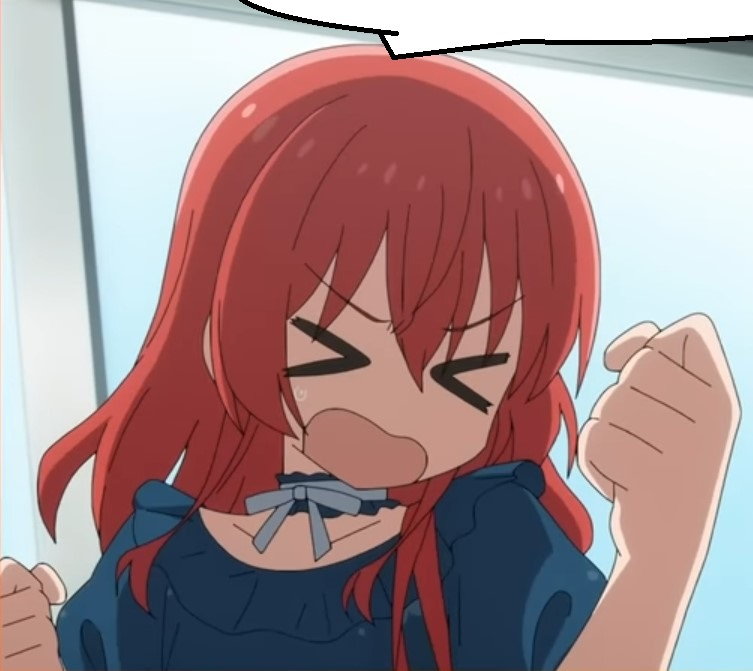

Enough the ranting, let's start with data normalization before we going for the actual pre-processing concept for NLU:

1. Make all words in the dataset lower case
2. Remove any punctuation characters
3. Remove Bahasa Indonesia stop words
4. Label's One-Hot Encoding


In [54]:
# Call out step 1
feature_train = feature_train.str.lower();
feature_test = feature_test.str.lower();
feature_val = feature_val.str.lower();

# Call out step 2
def remove_punctuation (text: str):
    punct_regex = r'[^\w\s]';
    clean_text = re.sub(punct_regex, "", text);
    return clean_text;

feature_train = feature_train.apply(lambda x: remove_punctuation(x));
feature_test = feature_test.apply(lambda x: remove_punctuation(x));
feature_val = feature_val.apply(lambda x: remove_punctuation(x));

# Call out step 3
stopword_factory = StopWordRemoverFactory();
stopwords = stopword_factory.get_stop_words();

def remove_stopword (text: str):
    # Splice the sentence into words
    words = text.split();

    # If word in current loop is not available in stopwords array, then save it to clean_words
    clean_words = [i for i in words if i not in stopwords];

    # Unsplice words into one sentence.
    return " ".join(clean_words);

feature_train = feature_train.apply(lambda x: remove_stopword(x));
feature_test = feature_test.apply(lambda x: remove_stopword(x));
feature_val = feature_val.apply(lambda x: remove_stopword(x));

# Call out step 4
label_train = pandas.get_dummies(label_train, prefix = "sentiment_");
label_test = pandas.get_dummies(label_test, prefix = "sentiment_");
label_val = pandas.get_dummies(label_val, prefix = "sentiment_");

There are few things to complete within dataset pre-processing for NLU case:

### 1. Slang Word Standardization
We have such beautiful community that keep texting with slang words. In other word, not removing slang-words may cause problems when stemming. So, this part will replace all those slang words, into standard one. 

But we also had beautiful community that provides such slang dataset. 
https://github.com/louisowen6/NLP_bahasa_resources/tree/master

The algorithm of this task is as follow:

> 1. Load `combined_slang_words.json` file
> 2. Loop through features data <br />
> 2.1 Splice the sentence <br />
> 2.2 For every word within sentence <br />
> 2.2.1 If this word is found on slang, then replace it with standard one <br />
> 2.2.2 Else, ignore. <br />
> 2.3 Unsplice the sentence <br />
> 3. Save the data

In [55]:
slang_db = json.load(open("../resources/combined_slang_words.json", "r"));

def slang_word_standardizer(text: str):
    words = text.split();
    clean_words = [slang_db.get(i, i) for i in words];

    return " ".join(clean_words);

feature_train = feature_train.apply(lambda x: slang_word_standardizer(x));
feature_test = feature_test.apply(lambda x: slang_word_standardizer(x));
feature_val = feature_val.apply(lambda x: slang_word_standardizer(x));


### 2. Lexical Analysis

This step normalize your text. Kind of doing "standardization". This step will include *Stemming*.

#### Stemming

Bahasa Indonesia had so many unnormal words ruling. By mean *unnormal*:

| Unnormal word | Stemming result |
|---|---|
| Memberikan | beri |
| Perekonomian | ekonomi |
| Pertumbuhan | tumbuh |
| Membanggakan | bangga |

*Bare with me

#### Lemmatization
Unfortunately, Sastrawi haven't made for Lemmatization we will skip the lemmatization for now.

In [57]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory;

factory = StemmerFactory();
stemmer = factory.create_stemmer();

tqdm.pandas();

# Apply stemmer
print("Stemming feature train");
feature_train = feature_train.progress_apply(lambda x: stemmer.stem(x));

print("Stemming feature test");
feature_test = feature_test.progress_apply(lambda x: stemmer.stem(x));

print("Stemming feature val");
feature_val = feature_val.progress_apply(lambda x: stemmer.stem(x));

Stemming feature train


  0%|          | 0/7564 [00:00<?, ?it/s]

  3%|▎         | 216/7564 [01:05<29:46,  4.11it/s]  